In [ ]:
# word feature vector:
# In natural language processing (NLP), a word embedding is a representation of a word. 
# The embedding is used in text analysis. Typically, the representation is a real-valued 
# vector that encodes the meaning of the word in such a way that words that are closer in 
# the vector space are expected to be similar in meaning. Word embeddings can be obtained 
# using language modeling and feature learning techniques, where words or phrases from the 
# vocabulary are mapped to vectors of real numbers. 
# https://en.wikipedia.org/wiki/Word_embedding
# https://www.youtube.com/watch?v=gQddtTdmG_8
# https://www.baeldung.com/cs/dimensionality-word-embeddings

In [3]:
# at first the words are initialized and spread out randomly
# then, we're gonna tune embeddings of these words using backprop
# by maximizing the log-likelihood

In [ ]:
# first few things were already done in bigram_basic

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
# load ~32000 names from a file, one in each line
with open("names.txt", "r") as infile:
    words = infile.read().splitlines() # ignores \n

In [6]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [7]:
len(words)

32033

In [8]:
chars = sorted(set("".join(words)))

In [27]:
ctoi = {c: i+1 for i, c in enumerate(chars)}
ctoi["."] = 0

In [28]:
itoc = {i: c for c, i in ctoi.items()}

In [ ]:
# now the new stuff

In [42]:
# building a neural network that takes three characters (a context)
# each character has an embedding in a lookup table
# the nn has 27 outputs corresponding to a letter that we expect to get from a given context
# we will check that using our Y tensor

In [626]:
# building the dataset (with contexts)

# training split -> ~80% -> optimize parameters of the model using gradient descent
# dev/validation split -> ~10% -> hyperparameter tuning
# test split -> ~10% -> evaluate model's final performance

# updated so that we can also create dev/test splits

block_size = 4 # context length - how many chars to take into account to predict the next one?

def build_dataset(words):
    X, Y = [], [] # X - input to the neural net, Y - expected labels for each example inside X
    
    for w in words:
        # print(w)
        context = [0] * block_size # ...
        for c in w + ".":
            idx = ctoi[c]
            X.append(context)
            Y.append(idx)
            # print("".join(itoc[i] for i in context), "--->", itoc[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182691, 4]) torch.Size([182691])
torch.Size([22793, 4]) torch.Size([22793])
torch.Size([22662, 4]) torch.Size([22662])


In [517]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [45]:
# embedding look-up table
# let's start with just 2 dimensions at first
C = torch.randn((27, 2)) # 27 because we need a 2 dim embedding for each letter

In [102]:
# some experiments to get a grasp of how that indexing works

In [84]:
C[:3]

tensor([[ 0.1316,  0.8406],
        [ 1.6549, -1.1986],
        [-0.2328, -2.5040]])

In [77]:
C[0]

tensor([0.1316, 0.8406])

In [99]:
C[0].shape

torch.Size([2])

In [85]:
C[[0, 1, 2]] # we can index with lists as well!

tensor([[ 0.1316,  0.8406],
        [ 1.6549, -1.1986],
        [-0.2328, -2.5040]])

In [100]:
C[[0, 1, 2]].shape

torch.Size([3, 2])

In [86]:
C[[torch.tensor([0, 1, 2])]] # same with tensors

tensor([[ 0.1316,  0.8406],
        [ 1.6549, -1.1986],
        [-0.2328, -2.5040]])

In [101]:
C[torch.tensor([[0, 1, 2], [1, 1, 1]])] # I finally get what that does now!

tensor([[[ 0.1316,  0.8406],
         [ 1.6549, -1.1986],
         [-0.2328, -2.5040]],

        [[ 1.6549, -1.1986],
         [ 1.6549, -1.1986],
         [ 1.6549, -1.1986]]])

In [98]:
C[[torch.tensor([[0, 1, 2], [1, 1, 1]])]].shape
# we have two contexts, three letters each
# C is a lookup table that has 2 dim embeddings for each letter
# C[0] simply gives an embedding of a single letter -> so shape 2
# C[[0, 1, 2]] gives embedding of a context (3 letters) -> shape 3, 2, an embedding for each letter
# C[ [[0, 1, 2], [1, 1, 1]] ] gives embedding for these 2 contexts -> shape 2 (new!), 3, 2

torch.Size([2, 3, 2])

In [89]:
X[:1]

tensor([[0, 0, 0]])

In [90]:
C[X[:1]]

tensor([[[0.1316, 0.8406],
         [0.1316, 0.8406],
         [0.1316, 0.8406]]])

In [91]:
X[:2]

tensor([[0, 0, 0],
        [0, 0, 5]])

In [92]:
C[X[:2]]

tensor([[[ 0.1316,  0.8406],
         [ 0.1316,  0.8406],
         [ 0.1316,  0.8406]],

        [[ 0.1316,  0.8406],
         [ 0.1316,  0.8406],
         [-0.8999, -0.8510]]])

In [93]:
C[X[:2]].shape

torch.Size([2, 3, 2])

In [103]:
# end of experiments

In [113]:
# so that's why C[X] will contain embeddings for all letters in all contexts -> shape 32, 3, 2
# 32 contexts, 3 letters each and each letter has a 2 dim embedding

In [117]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [107]:
# tests

In [109]:
X[13, 2] # 13th context, 2nd letter

tensor(1)

In [112]:
emb[13, 2] # embedding for that 13th context, 2nd letter

tensor([ 1.6549, -1.1986])

In [115]:
C[1] # embedding for letter with idx == 1, manually checked

tensor([ 1.6549, -1.1986])

In [116]:
# end of tests

In [120]:
# HIDDEN LAYER
# initialize weights randomly
W1 = torch.randn((3 * 2, 100)) # 3 * 2 cos 3 contexts times 2 dim embeddings give 6 numbers
# 100 is just a number of neurons in the hidden layer, might be different than 100 as well
b1 = torch.randn(100)

In [132]:
# we can't just do emb @ W1 + b1 because emb is [32, 2, 3] and W1 is [6, 100]
# that's why we need to flatten the emb matrix to [32, 6]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 100 activations for all 32 context embeddings ! ! !
h.shape
# + b1 requires broadcasting!
    # 32, 100
    #  1, 100 (1 - "fake" dimension)
# view is the most optimal, doesn't create anything additional in the memory
# check: tensor -> storage

torch.Size([32, 100])

In [133]:
# OUTPUT LAYER
W2 = torch.randn((100, 27)) # 100 input activations from prev layer, 27 letters as an output
b2 = torch.randn(27)

In [135]:
logits = h @ W2 + b2
logits.shape # good!

torch.Size([32, 27])

In [138]:
counts = logits.exp()
counts.shape

torch.Size([32, 27])

In [156]:
# broadcasting, 1 says we want sums of rows (a column vector, 27x1), every prob row gets divided by the row sum
prob = counts / counts.sum(1, keepdim=True)
prob.shape # 27 letter probs for all 32 context embeddings

torch.Size([32, 27])

In [159]:
prob[torch.arange(32), Y] # get all rows of prob and a probability of the correct letter (from Y)

tensor([5.2677e-05, 1.0049e-05, 8.2266e-03, 4.1967e-08, 1.3631e-13, 4.5783e-12,
        1.3816e-11, 1.1696e-08, 1.7143e-10, 2.9262e-08, 1.2633e-08, 1.1633e-12,
        4.9834e-12, 3.5899e-15, 1.2970e-15, 3.2741e-11, 7.8087e-08, 1.3296e-12,
        1.2381e-07, 6.7515e-01, 1.4482e-23, 1.0170e-08, 1.1195e-07, 1.3940e-11,
        6.5757e-12, 1.8048e-08, 7.2475e-11, 4.0650e-03, 1.2099e-09, 2.8398e-10,
        4.3487e-08, 3.1144e-13])

In [160]:
 nll_loss = -prob[torch.arange(32), Y].log().mean()

In [161]:
nll_loss

tensor(21.1892)

In [162]:
# NOW EVERYTHING ORGANIZED:

In [615]:
Xtr.shape, Ytr.shape # the dataset

(torch.Size([182484, 4]), torch.Size([182484]))

In [654]:
hidden_n = 200
emb_dim = 8

gen = torch.Generator().manual_seed(2147483647)
C = torch.randn((C.shape[0], emb_dim), generator=gen)
W1 = torch.randn((emb_dim * block_size, hidden_n), generator=gen)
b1 = torch.randn(hidden_n, generator=gen)
W2 = torch.randn((hidden_n, C.shape[0]), generator=gen)
b2 = torch.randn(C.shape[0], generator=gen)
parameters = [C, W1, b1, W2, b2]

In [655]:
sum(p.numel() for p in parameters) # numel <=> nelement

12243

In [656]:
for p in parameters:
    p.requires_grad = True

In [657]:
epochs = 200_000
minibatch_size = 500

loss_i = []

for i in range(epochs):
    # create a minibatch
    idx = torch.randint(0, Xtr.shape[0], (minibatch_size,)) # get 32 random integers
    # between 0 and 228146 (number of contexts)
    # that will be our minibatch (of size 32)
    
    # forward pass
    emb = C[Xtr[idx]]
    h = torch.tanh(emb.view(-1, emb_dim * block_size) @ W1 + b1) # hidden layer, (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # nll_loss = -prob[torch.arange(32), Y].log().mean()
    # nll_loss
    loss = F.cross_entropy(logits, Ytr[idx]) # more efficient, prevents inf and nan for big positive logits
    loss_i.append(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward() # it works but find out why later
    
    # update
    lr = 0.1 if i < epochs / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

print(loss.item())
# impossible to reach loss 0 because: ... -> e but also ... -> a, etc.

2.1099495887756348


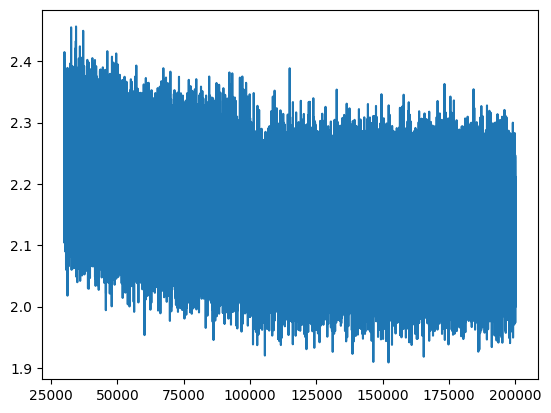

In [658]:
plt.plot(range(epochs)[30000:], loss_i[30000:])

In [659]:
# find out the loss for a whole (TR!) data set, not just a minibatch
emb = C[Xtr]
h = torch.tanh(emb.view(-1, emb_dim * block_size) @ W1 + b1) # hidden layer, (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr) # more efficient, prevents inf and nan for big positive logits
print(loss.item())

2.127196788787842


In [660]:
# tr loss ~= dev loss -> not overfitting (actually maybe underfitting!)
# <=> nn not able to memorize the values
# might mean that the network is too small (not enough parameters)

# find out the loss for a whole (DEV!) data set
emb = C[Xdev]
h = torch.tanh(emb.view(-1, emb_dim * block_size) @ W1 + b1) # hidden layer, (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev) # more efficient, prevents inf and nan for big positive logits
print(loss.item())

2.1558570861816406


In [672]:
# SAMPLING!!!
gen = torch.Generator().manual_seed(2147483647 + 19)

for _ in range(20):
    name = []
    context = [0] * block_size # initialize with all ...
    while True: # create one name
        emb = C[torch.tensor([context])] # like C[X] but this time only 1 context
        # block_size x emb_dim
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1, generator=gen).item()
        context = context[1:] + [idx]
        name.append(idx)
        if idx == 0:
            break
    print("".join(itoc[i] for i in name))
        

reige.
balmir.
bassin.
kari.
kier.
mane.
zakataytan.
lyam.
hamson.
razoni.
lilley.
ekvi.
nayvina.
elexy.
alah.
jeasiq.
briani.
heaz.
isley.
yailles.


In [359]:
C[X].shape, X.shape

(torch.Size([228146, 3, 2]), torch.Size([228146, 3]))

In [349]:
C[X[0]] # idx (here 0) gets 1 context of 3 letters (2 * 3 = 6 embeddings)

tensor([[ 2.7675, -0.1494],
        [ 2.7675, -0.1494],
        [ 2.7675, -0.1494]], grad_fn=<IndexBackward0>)

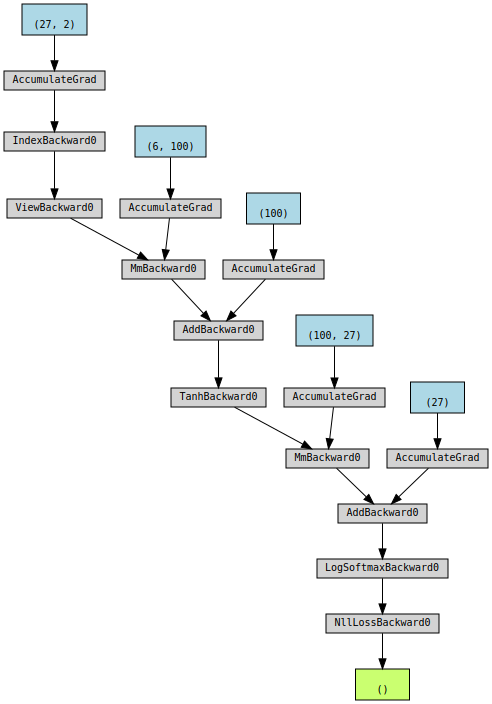

In [196]:
from torchviz import make_dot
from IPython.display import display
graph = make_dot(loss)
display(graph) # W O W ! ! ! ! ! ! !

In [197]:
# Save the graph as a PDF file
graph.render("computation_graph")

'computation_graph.pdf'

In [202]:
print(loss.grad_fn)

In [227]:
print(loss.grad_fn.next_functions)

((<LogSoftmaxBackward0 object at 0x7f664e776d10>, 0),)


In [226]:
print(loss.grad_fn.next_functions[0][0].next_functions)

((<AddBackward0 object at 0x7f664e630e20>, 0),)


In [229]:
print(loss.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
# etc. -> that's how we could build such graph!

((<MmBackward0 object at 0x7f664e6313c0>, 0), (<AccumulateGrad object at 0x7f664e631db0>, 0))
